
# KJV - NT Love vs OT Hate

In [2]:

!pip install gensim --upgrade --quiet

In [3]:

# import modules & set up logging
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

C:\Users\dev\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:

import csv

with open('../data/pg30.txt', 'r') as infile:
    reader = csv.reader(infile)
    sentences = [' '.join(row) for row in reader]

FileNotFoundError: [Errno 2] No such file or directory: '../data/pg30.txt'

In [4]:

import re

start = 94
stop = 114194
bible = sentences[start:stop]
ot_list = []
nt_list = []
book_regex = re.compile(r"^Book +(\d+)")
verse_regex = re.compile(r"^\d+:\d+:\d+\s+")
space_regex = re.compile(r" +")
line_list = ot_list

for line in bible:
    line = space_regex.sub(r" ", line)
    results = book_regex.search(line)
    if results:
        book_number = int(results.group(1))
        if book_number < 40:
            line_list = ot_list
        else:
            line_list = nt_list
    elif line == "":
        pass
    elif verse_regex.search(line):
        line_list.append(verse_regex.split(line)[-1].strip())
    else:
        line_list.append(line.strip())
print(ot_list[:4])
print(nt_list[:4])

['In the beginning God created the heaven and the earth.', 'And the earth was without form and void; and darkness was', 'upon the face of the deep. And the Spirit of God moved upon', 'the face of the waters.']
['The book of the generation of Jesus Christ the son of David', 'the son of Abraham.', 'Abraham begat Isaac; and Isaac begat Jacob; and Jacob begat', 'Judas and his brethren;']


In [5]:

import nltk.data
import time
import string

t0 = time.time()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
translate_table = dict((ord(char), None) for char in string.punctuation)
ot_sentences = [s.translate(translate_table).split(' ') for s in tokenizer.tokenize(" ".join(ot_list))]
nt_sentences = [s.translate(translate_table).split(' ') for s in tokenizer.tokenize(" ".join(nt_list))]
t1 = time.time()
print(t1-t0, time.ctime(t1))

1.2061727046966553 Thu Jun 29 20:52:14 2017


In [6]:

import gensim
import time

# train word2vec on the OT sentences
t0 = time.time()
ot_model = gensim.models.Word2Vec(ot_sentences, min_count=1)
nt_model = gensim.models.Word2Vec(nt_sentences, min_count=1)
t1 = time.time()
print(t1-t0, time.ctime(t1))

2.60988712310791 Thu Jun 29 20:52:17 2017


In [7]:

ot_hate_count = ot_model.wv.vocab['hate'].count
print(ot_hate_count)
ot_love_count = ot_model.wv.vocab['love'].count
print(ot_love_count)
nt_hate_count = nt_model.wv.vocab['hate'].count
print(nt_hate_count)
nt_love_count = nt_model.wv.vocab['love'].count
print(nt_love_count)

70
129
16
174


In [8]:

ot_total_words = 0
for word in ot_model.wv.vocab:
    ot_total_words += ot_model.wv.vocab[word].count
ot_total_words

609275

In [9]:

nt_total_words = 0
for word in nt_model.wv.vocab:
    nt_total_words += nt_model.wv.vocab[word].count
nt_total_words

180402

In [10]:

int(1000000*ot_hate_count/ot_total_words)

114

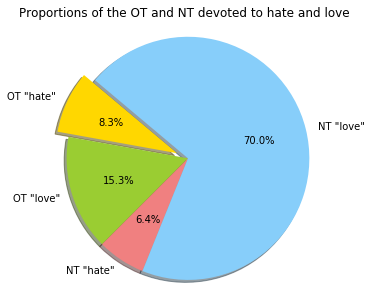

In [11]:

# Make a really fancy plot of the proportions of the OT and NT devoted to "hate" and "love"
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111, autoscale_on=True)
 
# Data to plot
labels = 'OT "hate"', 'OT "love"', 'NT "hate"', 'NT "love"'
sizes = [int(1000000*ot_hate_count/ot_total_words), 
         int(1000000*ot_love_count/ot_total_words), 
         int(1000000*nt_hate_count/nt_total_words), 
         int(1000000*nt_love_count/nt_total_words)]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
ax.axis('equal')

# Set labels
ax.set_title('Proportions of the OT and NT devoted to hate and love')

plt.savefig('./saves/' + plt.gca().get_title() + '.png')

In [23]:

print(ot_model.wv.most_similar(positive=['hate'], topn=5))
print(ot_model.wv.most_similar(positive=['love'], topn=5))
print(nt_model.wv.most_similar(positive=['hate'], topn=5))
print(nt_model.wv.most_similar(positive=['love'], topn=5))

[('suffered', 0.8765943050384521), ('abhor', 0.8745307326316833), ('cannot', 0.869989812374115), ('exalt', 0.8650345802307129), ('tear', 0.8566441535949707)]
[('forgive', 0.9033170342445374), ('desire', 0.8980228304862976), ('remember', 0.8803461790084839), ('forget', 0.8780404329299927), ('perform', 0.8738855123519897)]
[('accuse', 0.9978832006454468), ('follow', 0.9978269338607788), ('cannot', 0.9976128339767456), ('count', 0.9976098537445068), ('hypocrites', 0.9975418448448181)]
[('witness', 0.9970943331718445), ('truth', 0.9957135319709778), ('O', 0.9948419332504272), ('chosen', 0.994783878326416), ('serve', 0.994746744632721)]


In [24]:

ot_model.wv.doesnt_match("suffered abhor cannot exalt tear".split())

'cannot'

In [26]:

print(ot_model.wv.similarity('hate', 'love'))
print(nt_model.wv.similarity('hate', 'love'))

0.760830941708
0.977272672274


In [95]:

model.train([['this', 'is', 'a', 'sentence'], ['this', 'is', 'another', 'sentence']], total_examples=model.corpus_count,
           epochs=model.iter)

33